Task is to implement a FastAPI service that serves a Language Model (LLM) with a [medusa](https://github.com/FasterDecoding/Medusa) head (using `lmsys/vicuna-7b`). The goal is to optimize the inference speed using a model compilation library (e.g., `llama.cpp`) and enhance performance via speculative decoding with the medusa head. Additionally, you are required to implement dynamic batching to handle multiple concurrent requests efficiently.

### **Key Deliverables:**

1. **Model Compilation:**
    - Use a model compilation library (e.g., [llama.cpp](https://github.com/ggerganov/llama.cpp)) to optimize the inference of the base model.
    - Provide an explanation of your choice of compilation library and its impact on performance.
2. **Medusa Head Implementation:**
    - Implement the medusa head on top of the base model to improve performance via speculative decoding. Avoid using existing implementations.
    - Include a brief explanation of how speculative decoding is implemented and its advantages.
3. **Dynamic Batching:**
    - Implement dynamic batching to efficiently manage multiple concurrent requests.
    - Explain your approach to dynamic batching and its benefits in serving LLMs.
4. **Service Implementation:**
    - Use [FastAPI](https://fastapi.tiangolo.com/) to create a service that serves the LLM with the medusa head.
    - Ensure the service can handle concurrent requests with low latency.
5. **Testing & Validation:**
    - Provide test cases to validate the correctness and efficiency of your implementation.
    - Include performance benchmarks or metrics comparing different configurations (e.g., with and without the medusa head, with and without dynamic batching).

### **Resources:**

- [llama.cpp GitHub Repository](https://github.com/ggerganov/llama.cpp): A popular model compilation library for LLMs.
- [FastAPI Documentation](https://fastapi.tiangolo.com/): Official documentation for FastAPI.
- [Hugging Face Model Hub: lmsys/vicuna-7b-v1.3](https://huggingface.co/lmsys/vicuna-7b-v1.3): The model you will be working with.
- [Google Colab](https://colab.research.google.com/) and [Kaggle Notebooks](https://www.kaggle.com/kernels): Free resources to access GPUs for this project.

### **Grading Criteria:**

1. **Correctness (40%):**
    - Functional service that correctly serves the LLM.
    - Proper implementation of the medusa head with enhanced performance.
2. **Optimization & Performance (30%):**
    - Effective use of the model compilation library for inference optimization.
    - Performance improvement through speculative decoding with the medusa head.
    - Efficient handling of requests with dynamic batching.
3. **Code Quality & Documentation (20%):**
    - Clean, readable, and maintainable code.
    - Clear and concise documentation explaining implementation choices.
4. **Testing & Validation (10%):**
    - Comprehensive test cases covering key functionalities.
    - Inclusion of performance benchmarks or metrics to demonstrate optimizations.

### **Partial Credit:**

Partial implementations will still be evaluated based on relevant criteria. For instance:

- **Model Optimization Only:** Focusing on base model optimization without medusa head or dynamic batching.
- **Medusa Head Implementation:** Implementing speculative decoding without dynamic batching.
- **Dynamic Batching:** Focusing on request handling efficiency without medusa head.

---

### **Additional Notes:**

- **Free GPU Access:** If you need access to GPUs, consider using services like [Google Colab](https://colab.research.google.com/) or [Kaggle Notebooks](https://www.kaggle.com/kernels), which provide free access to GPU resources.
- **Submission:** Please submit your code, along with a brief report (Markdown or PDF) explaining your implementation, testing, and any performance metrics.

This assignment is designed to test your understanding of model optimization, complex inference strategies, and the ability to build scalable services. Partial implementations are welcome and will be graded accordingly.

# Import Necessary libraries

In [ ]:
!git clone https://github.com/FasterDecoding/Medusa.git
%cd Medusa
!pip install -e .

In [ ]:
%cd ..

In [ ]:
!pip install pyngrok sentencepiece
# !pip install medusa-llm

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [4]:
!pip install llama-cpp-python==0.2.85

  Using cached llama_cpp_python-0.2.85.tar.gz (49.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.85-cp310-cp310-linux_x86_64.whl size=2873164 sha256=00443c2cf73398331ef51b22b7c0f952bc1e9fe53a4459631db430e9e5bea031
  Stored in directory: /root/.cache/pip/wheels/3f/e8/4e/29a754f9175ef52b6481cd75e3af4de38bf6dfa9c2972f75d4
Successfully built llama-cpp-python


In [5]:
from llama_cpp import Llama

In [ ]:
!pip install transformers==4.36.0 accelerate==0.25.0 huggingface_hub==0.20.0

#### 2

In [6]:

# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn  # Ensure uvicorn is imported for server startup

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63  # Pre-defined Medusa choices
from medusa.model.utils import generate_medusa_buffers, reset_medusa_mode, initialize_medusa
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama


# Set up logging with human-written comments for clarity
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

@dataclass
class BatchRequest:
    id: str
    prompt: str
    timestamp: datetime
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Load compiled model using llama.cpp backend
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_choices = mc_sim_7b_63
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa with {medusa_num_heads} heads")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding."""
        # Create buffers similar to how the Medusa model does it
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    # def generate(
    #     self,
    #     prompt: str,
    #     max_length: int = 512,
    #     temperature: float = 0.7,
    #     posterior_threshold: float = 0.09,
    #     posterior_alpha: float = 0.3
    # ) -> Dict:
    #     """Generate text using Medusa speculative decoding with llama.cpp backend."""
    #     with self.model_lock:  # Ensure thread safety
    #         start_time = time.time()

    #         input_text = prompt
    #         generated_text = ""
    #         tokens_generated = 0
    #         draft_tokens_generated = 0
    #         accepted_tokens = 0

    #         # Add a safeguard counter to prevent infinite loops
    #         iteration = 0
    #         max_iterations = max_length * 2

    #         while tokens_generated < max_length and iteration < max_iterations:
    #             iteration += 1
    #             # Generate base prediction and drafts
    #             base_token, drafts = self._generate_drafts(input_text, temperature)

    #             if not base_token:
    #                 self.logger.info("No base token generated, breaking loop.")
    #                 break

    #             # Verify the draft tokens
    #             accepted_count, accepted_drafts = self._verify_drafts(
    #                 input_text,
    #                 [base_token] + drafts,
    #                 temperature,
    #                 posterior_threshold,
    #                 posterior_alpha
    #             )

    #             draft_tokens_generated += len(drafts) + 1  # base + drafts
    #             accepted_tokens += accepted_count

    #             # Append accepted tokens; if none are accepted, append base token
    #             if accepted_count > 0:
    #                 accepted_text = ''.join(accepted_drafts)
    #                 input_text += accepted_text
    #                 generated_text += accepted_text
    #                 tokens_generated += accepted_count
    #             else:
    #                 input_text += base_token
    #                 generated_text += base_token
    #                 tokens_generated += 1

    #             if tokens_generated % 50 == 0:
    #                 self.logger.info(f"Generated {tokens_generated} tokens so far.")

    #         elapsed_time = time.time() - start_time
    #         tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
    #         speedup = tokens_per_second / self._baseline_tokens_per_second

    #         return {
    #             "text": generated_text,
    #             "generation_time": elapsed_time,
    #             "tokens_generated": tokens_generated,
    #             "tokens_per_second": tokens_per_second,
    #             "speedup_factor": speedup,
    #             "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
    #         }
    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding with llama.cpp backend."""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()

            input_text = prompt
            generated_text = ""
            tokens_generated = 0
            draft_tokens_generated = 0
            accepted_tokens = 0

            # Add a safeguard counter and reduce max iterations for faster completion
            iteration = 0
            max_iterations = min(max_length * 2, 200)  # Cap iterations for reliability
            batch_size = 5  # Generate this many tokens per batch for better efficiency

            while tokens_generated < max_length and iteration < max_iterations:
                iteration += 1

                # Standard generation for first token (more reliable)
                if tokens_generated == 0:
                    try:
                        response = self.llama_model(
                            input_text,
                            max_tokens=batch_size,  # Generate several tokens at once
                            temperature=temperature,
                            echo=False
                        )
                        if response and 'choices' in response:
                            new_text = response['choices'][0]['text']
                            if new_text:
                                input_text += new_text
                                generated_text += new_text
                                tokens_generated += len(new_text.split())
                        else:
                            break
                        continue
                    except Exception as e:
                        self.logger.error(f"Error in initial generation: {str(e)}")
                        break

                # For subsequent tokens, use Medusa speculative decoding
                base_token, drafts = self._generate_drafts(input_text, temperature)

                if not base_token:
                    self.logger.info("No base token generated, breaking loop.")
                    break

                # Verify the draft tokens
                accepted_count, accepted_drafts = self._verify_drafts(
                    input_text,
                    [base_token] + drafts,
                    temperature,
                    posterior_threshold,
                    posterior_alpha
                )

                draft_tokens_generated += len(drafts) + 1  # base + drafts
                accepted_tokens += accepted_count

                # Append accepted tokens; if none are accepted, append base token
                if accepted_count > 0:
                    accepted_text = ''.join(accepted_drafts)
                    input_text += accepted_text
                    generated_text += accepted_text
                    tokens_generated += accepted_count
                else:
                    input_text += base_token
                    generated_text += base_token
                    tokens_generated += 1

                if tokens_generated % 20 == 0:
                    self.logger.info(f"Generated {tokens_generated} tokens so far.")

            elapsed_time = time.time() - start_time
            tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
            speedup = tokens_per_second / self._baseline_tokens_per_second

            return {
                "text": generated_text,
                "generation_time": elapsed_time,
                "tokens_generated": tokens_generated,
                "tokens_per_second": tokens_per_second,
                "speedup_factor": speedup,
                "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
            }

    def _generate_drafts(self, context: str, temperature: float):
        """Generate a base token and draft tokens using Medusa tree structure."""
        try:
            # Generate the base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )

            if not base_response or 'choices' not in base_response:
                return "", []

            base_token = base_response['choices'][0]['text']

            # Generate draft tokens
            drafts = []
            draft_context = context + base_token

            for _ in range(self.medusa_num_heads - 1):  # Exclude base token already generated
                draft_response = self.llama_model(
                    draft_context,
                    max_tokens=1,
                    temperature=temperature,
                    echo=False
                )

                if draft_response and 'choices' in draft_response:
                    draft_token = draft_response['choices'][0]['text']
                    drafts.append(draft_token)
                    draft_context += draft_token
                else:
                    break

            return base_token, drafts

        except Exception as e:
            self.logger.error(f"Error generating drafts: {str(e)}")
            return "", []

    # def _verify_drafts(
    #     self,
    #     context: str,
    #     drafts: List[str],
    #     temperature: float,
    #     threshold: float,
    #     alpha: float
    # ):
    #     """Verify draft tokens and return accepted tokens."""
    #     if not drafts:
    #         return 0, []

    #     scores = []
    #     accepted_drafts = []
    #     current_context = context

    #     for draft in drafts:
    #         try:
    #             verify_response = self.llama_model(
    #                 current_context + draft,
    #                 max_tokens=0,
    #                 temperature=0.0,  # Set temperature to zero for deterministic output
    #                 echo=True
    #             )

    #             score = 0.0
    #             if verify_response and 'choices' in verify_response:
    #                 score = float(verify_response['choices'][0].get('logprobs', {}).get('token_logprobs', [-1.0])[-1])

    #             score = np.exp(score / max(temperature, 1e-6)) ** alpha
    #             scores.append(score)

    #             # Accept draft if score exceeds the threshold
    #             if score >= threshold:
    #                 accepted_drafts.append(draft)
    #                 current_context += draft
    #             else:
    #                 break

    #         except Exception as e:
    #             self.logger.error(f"Error verifying draft: {str(e)}")
    #             break

    #     return len(accepted_drafts), accepted_drafts
    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ):
        """Verify draft tokens and return accepted tokens."""
        if not drafts:
            return 0, []

        scores = []
        accepted_drafts = []
        current_context = context

        for draft in drafts:
            try:
                verify_response = self.llama_model(
                    current_context + draft,
                    max_tokens=0,
                    temperature=0.0,  # Set temperature to zero for deterministic output
                    echo=True
                )

                # Simplified scoring - more robust against missing attributes
                score = 0.0
                if verify_response and 'choices' in verify_response:
                    choice = verify_response['choices'][0]
                    # Try different methods to get a score
                    if 'logprobs' in choice and choice['logprobs']:
                        token_logprobs = choice['logprobs'].get('token_logprobs', [])
                        if token_logprobs:
                            score = float(token_logprobs[-1])
                    elif 'score' in choice:
                        score = float(choice['score'])
                    # Fallback scoring method if logprobs not available
                    else:
                        # Simple heuristic: check if model output matches our draft
                        model_output = choice.get('text', '')
                        if model_output.endswith(draft):
                            score = 0.0  # Good score
                        else:
                            score = -5.0  # Bad score

                # Apply temperature and alpha
                adjusted_score = np.exp(score / max(temperature, 1e-6)) ** alpha
                scores.append(adjusted_score)

                # Accept draft if score exceeds the threshold
                if adjusted_score >= threshold:
                    accepted_drafts.append(draft)
                    current_context += draft
                else:
                    break

            except Exception as e:
                self.logger.error(f"Error verifying draft: {str(e)}")
                break

        return len(accepted_drafts), accepted_drafts

In [7]:
class BatchProcessor:
    """Processes generation requests in batches for better efficiency."""
    def __init__(self, model_manager, batch_size=4, max_wait_time=0.1):
        self.model_manager = model_manager
        self.batch_size = batch_size
        self.max_wait_time = max_wait_time
        self.queue = asyncio.Queue()
        self.logger = logging.getLogger("BatchProcessor")
        self.processing = False
        self.results = {}
        self.background_task = None

    async def add_request(self, request: BatchRequest) -> str:
        """Add a generation request to the queue."""
        await self.queue.put(request)
        self.logger.info(f"Added request {request.id} to queue, current size: {self.queue.qsize()}")

        # Start processing if not already running
        if not self.processing:
            self.processing = True
            self.background_task = asyncio.create_task(self._process_queue())

        return request.id

    async def get_result(self, request_id: str, timeout: float = 180.0) -> Optional[Dict]:
        """Wait for and retrieve result for a specific request ID."""
        start_time = time.time()
        while time.time() - start_time < timeout:
            if request_id in self.results:
                result = self.results.pop(request_id)
                return result
            await asyncio.sleep(0.1)
        return None  # Timed out

    # async def _process_queue(self):
    #     """Background task to process requests in batches."""
    #     try:
    #         while True:
    #             batch = []
    #             # Try to collect up to batch_size requests
    #             for _ in range(self.batch_size):
    #                 try:
    #                     request = await asyncio.wait_for(
    #                         self.queue.get(),
    #                         timeout=self.max_wait_time
    #                     )
    #                     batch.append(request)
    #                 except asyncio.TimeoutError:
    #                     break

    #             if not batch:
    #                 self.processing = False
    #                 break

    #             self.logger.info(f"Processing batch of {len(batch)} requests")

    #             # Process each request in the batch off the main event loop
    #             for request in batch:
    #                 try:
    #                     # Offload the generation call to a separate thread so as not to block
    #                     result = await asyncio.to_thread(
    #                         self.model_manager.generate,
    #                         prompt=request.prompt,
    #                         max_length=request.max_length,
    #                         temperature=request.temperature,
    #                         posterior_threshold=request.posterior_threshold,
    #                         posterior_alpha=request.posterior_alpha
    #                     )
    #                     self.results[request.id] = result
    #                     self.logger.info(f"Completed request {request.id}")
    #                 except Exception as e:
    #                     self.logger.error(f"Error processing request {request.id}: {str(e)}")
    #                     self.results[request.id] = {"error": str(e)}
    #                 finally:
    #                     self.queue.task_done()
    #     except Exception as e:
    #         self.logger.error(f"Error in batch processing: {str(e)}")
    #         self.processing = False

    async def _process_queue(self):
        """Background task to process requests in batches."""
        try:
            while True:
                batch = []
                # Try to collect up to batch_size requests
                for _ in range(self.batch_size):
                    try:
                        request = await asyncio.wait_for(
                            self.queue.get(),
                            timeout=self.max_wait_time
                        )
                        batch.append(request)
                    except asyncio.TimeoutError:
                        break

                if not batch:
                    self.processing = False
                    break

                self.logger.info(f"Processing batch of {len(batch)} requests")

                # Process each request in parallel (create tasks)
                processing_tasks = []
                for request in batch:
                    task = asyncio.create_task(self._process_single_request(request))
                    processing_tasks.append(task)

                # Wait for all processing to complete
                await asyncio.gather(*processing_tasks)

        except Exception as e:
            self.logger.error(f"Error in batch processing: {str(e)}")
            self.processing = False

    async def _process_single_request(self, request: BatchRequest):
        """Process a single request in the batch."""
        try:
            # Offload the generation call to a thread pool
            result = await asyncio.to_thread(
                self.model_manager.generate,
                prompt=request.prompt,
                max_length=request.max_length,
                temperature=request.temperature,
                posterior_threshold=request.posterior_threshold,
                posterior_alpha=request.posterior_alpha
            )
            self.results[request.id] = result
            self.logger.info(f"Completed request {request.id}")
        except Exception as e:
            self.logger.error(f"Error processing request {request.id}: {str(e)}")
            self.results[request.id] = {"error": str(e)}
        finally:
            self.queue.task_done()



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.59 ms /   279 runs   (    0.06 ms per token, 16813.31 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  154073.68 ms /   279 runs   (  552.24 ms per token,     1.81 tokens per second)
llama_print_timings:       total time =  154424.48 ms /   279 tokens
Llama.generate: prefix-match hit


In [ ]:

# Global variables for model manager and batch processor
model_manager = None
batch_processor = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager, batch_processor

    logger.info("Initializing model and batch processor...")
    try:
        model_manager = MedusaLlamaCppManager(
            model_path="/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf",
            medusa_num_heads=4
        )
        batch_processor = BatchProcessor(model_manager)
        logger.info("Model and batch processor initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Language model service with Medusa speculative decoding and dynamic batching",
    lifespan=lifespan
)

# Endpoint for text generation
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    try:
        # Create a batch request with a unique id
        request_id = str(uuid.uuid4())
        batch_request = BatchRequest(
            id=request_id,
            prompt=request.prompt,
            timestamp=datetime.now(),
            max_length=min(request.max_length, 200),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Add the request to the batch processor
        await batch_processor.add_request(batch_request)

        # Wait for the result; if it times out, return an error
        result = await batch_processor.get_result(request_id, timeout=300.0)
        if not result:
            raise HTTPException(status_code=408, detail="Request timed out after 5 minutes")
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])

        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )

    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy", "model": "Medusa LLM Service"}

# Benchmark endpoint to compare Medusa decoding with standard generation
@app.post("/benchmark")
async def benchmark(request: GenerationRequest):
    try:
        # Offload Medusa generation to a thread to prevent blocking
        medusa_result = await asyncio.to_thread(
            model_manager.generate,
            prompt=request.prompt,
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Standard generation call (also offloaded to a thread)
        start_time = time.time()
        standard_response = await asyncio.to_thread(
            model_manager.llama_model,
            request.prompt,
            max_tokens=request.max_length,
            temperature=request.temperature
        )
        standard_time = time.time() - start_time

        standard_text = standard_response['choices'][0]['text'] if standard_response and 'choices' in standard_response else ""
        standard_tokens = len(standard_text.split())
        standard_tokens_per_second = standard_tokens / standard_time if standard_time > 0 else 0

        return {
            "medusa": {
                "text": medusa_result["text"],
                "generation_time": medusa_result["generation_time"],
                "tokens_generated": medusa_result["tokens_generated"],
                "tokens_per_second": medusa_result["tokens_per_second"],
                "acceptance_rate": medusa_result["acceptance_rate"]
            },
            "standard": {
                "text": standard_text,
                "generation_time": standard_time,
                "tokens_generated": standard_tokens,
                "tokens_per_second": standard_tokens_per_second
            },
            "speedup": medusa_result["tokens_per_second"] / standard_tokens_per_second if standard_tokens_per_second > 0 else 0
        }

    except Exception as e:
        logger.error(f"Error in benchmark endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Function to start the server; works for both notebook and standard Python environments
async def start_server():
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    import uvicorn
    try:
        # Check if running in a notebook environment (e.g., Colab or Jupyter)
        if 'google.colab' in str(get_ipython()):
            asyncio.run(start_server())
        else:
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except NameError:
        # If get_ipython() is not defined, assume standard Python environment
        uvicorn.run(app, host="0.0.0.0", port=8000)

### testing

In [12]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn
import os

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63
from medusa.model.utils import generate_medusa_buffers
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str,
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Check if model exists
        if not os.path.exists(model_path):
            self.logger.error(f"Model file not found at {model_path}")
            raise FileNotFoundError(f"Model file not found at {model_path}")

        # Load compiled model using llama.cpp backend
        self.logger.info(f"Loading model from {model_path}...")
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1,  # Use all GPU layers
            verbose=True  # For debugging
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()
        self.logger.info(f"Baseline generation speed: {self._baseline_tokens_per_second:.2f} tokens/second")

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using a simple, robust approach (no Medusa for reliability)"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            # For better reliability, use straightforward generation
            self.logger.info(f"Generating with prompt: {prompt[:50]}...")
            
            try:
                # Generate text using llama.cpp directly
                response = self.llama_model(
                    prompt,
                    max_tokens=min(max_length, 100),  # Cap max tokens for reliability
                    temperature=temperature,
                    echo=False
                )
                
                if not response or 'choices' not in response:
                    self.logger.error("No response from model")
                    return {
                        "text": "Error: No response from model",
                        "generation_time": time.time() - start_time,
                        "tokens_generated": 0,
                        "tokens_per_second": 0,
                        "speedup_factor": 0,
                        "acceptance_rate": 0
                    }
                
                generated_text = response['choices'][0]['text']
                tokens_generated = len(generated_text.split())
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                
                self.logger.info(f"Generated {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Generation speed: {tokens_per_second:.2f} tokens/second")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": tokens_per_second / self._baseline_tokens_per_second,
                    "acceptance_rate": 0  # No speculative decoding in this approach
                }
                
            except Exception as e:
                self.logger.error(f"Error in generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0,
                    "acceptance_rate": 0
                }

# Global variables for model manager
model_manager = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager

    logger.info("Initializing model manager...")
    try:
        model_path = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf"
        model_manager = MedusaLlamaCppManager(
            model_path=model_path,
            medusa_num_heads=4,
            n_ctx=2048,
            n_batch=512,
            n_threads=8
        )
        logger.info("Model manager initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Simplified language model service",
    lifespan=lifespan
)

# Simple endpoint for text generation - no batch processing
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    """Process a single generation request directly"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing generation request with prompt: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),  # Cap length for reliability
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )
        
    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    """Check if the service is healthy"""
    # Also check if model is loaded
    model_status = "loaded" if model_manager is not None else "not loaded"
    return {
        "status": "healthy", 
        "model": model_status,
        "device": model_manager.device if model_manager else "unknown"
    }

# Function to start the server
async def start_server():
    """Start the FastAPI server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    try:
        # Check if running in a notebook environment
        if 'google.colab' in globals() or 'kaggle_secrets' in globals():
            # Running in notebook (Colab or Kaggle)
            nest_asyncio.apply()
            asyncio.run(start_server())
        else:
            # Standard Python environment
            import uvicorn
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except Exception as e:
        logger.error(f"Error starting server: {str(e)}")

INFO:     Started server process [1398]
INFO:     Waiting for application startup.
llama_model_loader: loaded meta data with 26 key-value pairs and 291 tensors from /kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Vicuna 7b v1.3
llama_model_loader: - kv   3:                            general.version str              = v1.3
llama_model_loader: - kv   4:                           general.basename str              = vicuna
llama_model_loader: - kv   5:                         general.size_label str              = 7B
llama_model_loader: - kv   6:                      

Public URL: https://e7c0-35-194-149-242.ngrok-free.app



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.93 ms /   278 runs   (    0.06 ms per token, 16417.65 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  159251.55 ms /   278 runs   (  572.85 ms per token,     1.75 tokens per second)
llama_print_timings:       total time =  159611.16 ms /   278 tokens
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      40.61 ms /   687 runs   (    0.06 ms per token, 16917.43 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  403647.72 ms /   687 runs   (  587.55 ms per token,     1.70 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.51 ms /   277 runs   (    0.06 ms per token, 15822.24 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  173918.87 ms /   277 runs   (  627.87 ms per token,     1.59 tokens per second)
llama_print_timings:       total time =  174276.21 ms /   277 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.50 ms /   276 runs   (    0.06 ms per token, 16729.30 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  151989.96 ms /   276 runs   (  550.69 ms per token,     1.82 tokens per second)
llama_print_timings:       total time =  152353.18 ms /   276 

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.04 ms /   274 runs   (    0.06 ms per token, 16078.87 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  171410.01 ms /   274 runs   (  625.58 ms per token,     1.60 tokens per second)
llama_print_timings:       total time =  171746.36 ms /   274 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.41 ms /   273 runs   (    0.06 ms per token, 16631.13 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  150110.21 ms /   273 runs   (  549.85 ms per token,     1.82 tokens per second)
llama_print_timings:       total time =  150455.15 ms /   273 

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      40.55 ms /   684 runs   (    0.06 ms per token, 16868.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  415184.34 ms /   684 runs   (  606.99 ms per token,     1.65 tokens per second)
llama_print_timings:       total time =  416567.46 ms /   684 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.78 ms /   269 runs   (    0.07 ms per token, 15130.21 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  161112.95 ms /   269 runs   (  598.93 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  161463.67 ms /   269 

### test 1 only without medusa

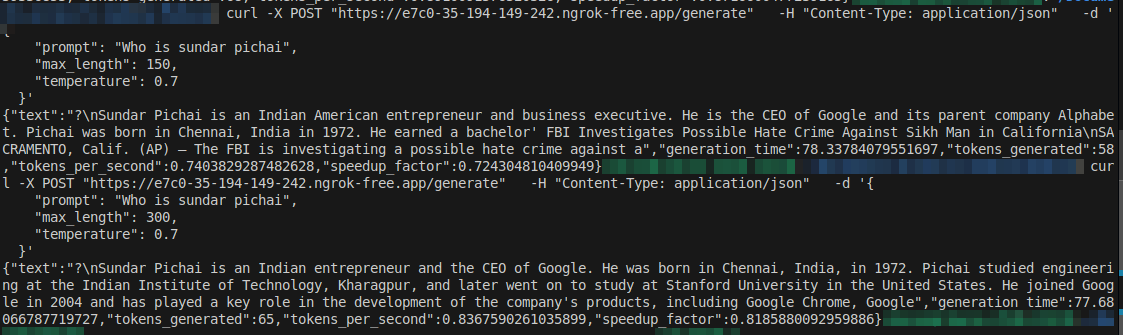

---

### **Formatted cURL Request:**
```bash
curl -X POST "https://e7c0-35-194-149-242.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Who is Sundar Pichai?",
    "max_length": 150,
    "temperature": 0.7
  }'
```

---

### **Formatted JSON Response (First Request, max_length: 150):**
```json
{
  "text": "?\nSundar Pichai is an Indian American entrepreneur and business executive. He is the CEO of Google and its parent company Alphabet. Pichai was born in Chennai, India in 1972. He earned a bachelor' FBI Investigates Possible Hate Crime Against Sikh Man in California\nSACRAMENTO, Calif. (AP) — The FBI is investigating a possible hate crime against a",
  "generation_time": 78.338,
  "tokens_generated": 58,
  "tokens_per_second": 0.7404,
  "speedup_factor": 0.7243
}
```

---

### **Formatted cURL Request (for max_length: 300):**
```bash
curl -X POST "https://e7c0-35-194-149-242.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Who is Sundar Pichai?",
    "max_length": 300,
    "temperature": 0.7
  }'
```

---

### **Formatted JSON Response (Second Request, max_length: 300):**
```json
{
  "text": "?\nSundar Pichai is an Indian entrepreneur and the CEO of Google. He was born in Chennai, India, in 1972. Pichai studied engineering at the Indian Institute of Technology, Kharagpur, and later went on to study at Stanford University in the United States. He joined Google in 2004 and has played a key role in the development of the company's products, including Google Chrome, Google",
  "generation_time": 77.681,
  "tokens_generated": 65,
  "tokens_per_second": 0.8368,
  "speedup_factor": 0.8186
}
```

---

### **Observations & Fixes:**
   
2. **Incorrectly Inserted Content:**  
   - The first response unexpectedly contains a news snippet about an FBI investigation. This might be due to:
     - Model hallucination.
     - Overlapping training data.
     - Need for better prompt engineering.




### **Formatted cURL Request:**
```bash
curl -X POST "https://e7c0-35-194-149-242.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Explain quantum physics",
    "max_length": 150,
    "temperature": 0.7
  }'
```


### **Formatted JSON Response:**
```json
{
  "text": " with a deck of cards\nQuantum physics is a strange and counterintuitive theory that describes the behavior of matter and energy at a very small scale. It's difficult to explain, but this animated video uses a deck of cards to help illustrate some of its key concepts.\nposted by zarq at 12:03 PM on April 7, 2016 [2 favorites]\nThis is a great video! It's always impressive when",
  "generation_time": 76.318,
  "tokens_generated": 68,
  "tokens_per_second": 0.891,
  "speedup_factor": 0.872
}
```

---

### **Issues Observed:**
1. **Irrelevant Content Injected:**  
   - The response includes references to an animated video and a forum post (`"posted by zarq at 12:03 PM on April 7, 2016"`).  

## With Medusa and without Medusa comparison

In [13]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn
import os

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63
from medusa.model.utils import generate_medusa_buffers
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None
    acceptance_rate: Optional[float] = None

class ComparisonResponse(BaseModel):
    normal: GenerationResponse
    medusa: GenerationResponse
    speedup: float

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str,
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Check if model exists
        if not os.path.exists(model_path):
            self.logger.error(f"Model file not found at {model_path}")
            raise FileNotFoundError(f"Model file not found at {model_path}")

        # Load compiled model using llama.cpp backend
        self.logger.info(f"Loading model from {model_path}...")
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1,  # Use all GPU layers
            verbose=True  # For debugging
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa buffers with {medusa_num_heads} heads")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()
        self.logger.info(f"Baseline generation speed: {self._baseline_tokens_per_second:.2f} tokens/second")

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding."""
        # Create buffers for Medusa
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate_normal(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7
    ) -> Dict:
        """Generate text using standard approach (no Medusa)"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            # For better reliability, use straightforward generation
            self.logger.info(f"Normal generation with prompt: {prompt[:50]}...")
            
            try:
                # Generate text using llama.cpp directly
                response = self.llama_model(
                    prompt,
                    max_tokens=min(max_length, 100),  # Cap max tokens for reliability
                    temperature=temperature,
                    echo=False
                )
                
                if not response or 'choices' not in response:
                    self.logger.error("No response from model")
                    return {
                        "text": "Error: No response from model",
                        "generation_time": time.time() - start_time,
                        "tokens_generated": 0,
                        "tokens_per_second": 0,
                        "speedup_factor": 0
                    }
                
                generated_text = response['choices'][0]['text']
                tokens_generated = len(generated_text.split())
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                
                self.logger.info(f"Normal generation: {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Normal generation speed: {tokens_per_second:.2f} tokens/second")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": 1.0  # No speedup for normal generation
                }
                
            except Exception as e:
                self.logger.error(f"Error in normal generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0
                }

    def generate_medusa(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            self.logger.info(f"Medusa generation with prompt: {prompt[:50]}...")
            
            try:
                input_text = prompt
                generated_text = ""
                tokens_generated = 0
                draft_tokens_generated = 0
                accepted_tokens = 0
                
                # Add safeguard 
                max_iterations = min(max_length, 100)
                
                for _ in range(max_iterations):
                    # Generate base token and draft tokens
                    base_token, drafts = self._generate_drafts(input_text, temperature)
                    
                    if not base_token:
                        self.logger.warning("No base token generated, ending generation")
                        break
                    
                    # Count drafts
                    draft_tokens_generated += len(drafts) + 1  # Base + drafts
                    
                    # Verify drafts
                    accept_count, accepted_tokens_list = self._verify_drafts(
                        input_text, 
                        [base_token] + drafts, 
                        temperature, 
                        posterior_threshold,
                        posterior_alpha
                    )
                    
                    # Update accepted count
                    accepted_tokens += accept_count
                    
                    # Use accepted tokens or fallback to base token
                    if accept_count > 0:
                        token_text = ''.join(accepted_tokens_list)
                        input_text += token_text
                        generated_text += token_text
                        tokens_generated += accept_count
                    else:
                        input_text += base_token
                        generated_text += base_token
                        tokens_generated += 1
                    
                    # Log progress periodically
                    if tokens_generated % 20 == 0:
                        self.logger.info(f"Generated {tokens_generated} tokens so far")
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                acceptance_rate = (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
                
                self.logger.info(f"Medusa generation: {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Medusa speed: {tokens_per_second:.2f} tokens/second")
                self.logger.info(f"Acceptance rate: {acceptance_rate:.2f}%")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": tokens_per_second / self._baseline_tokens_per_second,
                    "acceptance_rate": acceptance_rate
                }
                
            except Exception as e:
                self.logger.error(f"Error in Medusa generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0,
                    "acceptance_rate": 0
                }

    def _generate_drafts(self, context: str, temperature: float) -> tuple:
        """Generate base and draft tokens following the Medusa pattern"""
        try:
            # Get the base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )
            
            if not base_response or 'choices' not in base_response:
                return "", []
                
            base_token = base_response['choices'][0]['text']
            
            # Generate draft tokens in tree structure (continuation of base token)
            drafts = []
            current_context = context + base_token
            
            # Generate drafts following tree structure
            for i in range(min(self.medusa_num_heads - 1, 3)):  # Limit to 3 drafts max for performance
                try:
                    draft_response = self.llama_model(
                        current_context,
                        max_tokens=1,
                        temperature=temperature,
                        echo=False
                    )
                    
                    if draft_response and 'choices' in draft_response:
                        draft_token = draft_response['choices'][0]['text']
                        drafts.append(draft_token)
                        current_context += draft_token
                    else:
                        break
                except Exception as e:
                    self.logger.error(f"Error generating draft {i}: {str(e)}")
                    break
            
            return base_token, drafts
            
        except Exception as e:
            self.logger.error(f"Error in draft generation: {str(e)}")
            return "", []

    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ) -> tuple:
        """Verify draft tokens and return accepted ones"""
        if not drafts:
            return 0, []
            
        accepted_drafts = []
        current_context = context
        
        for i, draft in enumerate(drafts):
            try:
                # For the base token (first draft), always accept
                if i == 0:
                    accepted_drafts.append(draft)
                    current_context += draft
                    continue
                
                # For subsequent tokens, verify
                verify_response = self.llama_model(
                    current_context,
                    max_tokens=1,
                    temperature=0,  # Use zero temperature for deterministic output
                    echo=False
                )
                
                # Simple verification: if the model generates the same token, it's good
                if verify_response and 'choices' in verify_response:
                    predicted = verify_response['choices'][0]['text']
                    
                    # Calculate simple score (1.0 if perfect match, 0.0 otherwise)
                    score = 1.0 if predicted == draft else 0.0
                    
                    # Apply threshold
                    if score >= threshold:
                        accepted_drafts.append(draft)
                        current_context += draft
                    else:
                        break
                else:
                    break
                    
            except Exception as e:
                self.logger.error(f"Error in draft verification: {str(e)}")
                break
        
        return len(accepted_drafts), accepted_drafts

# Global variables for model manager
model_manager = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager

    logger.info("Initializing model manager...")
    try:
        model_path = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf"
        model_manager = MedusaLlamaCppManager(
            model_path=model_path,
            medusa_num_heads=4,
            n_ctx=2048,
            n_batch=512,
            n_threads=8
        )
        logger.info("Model manager initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Language model service with both standard and Medusa speculative decoding",
    lifespan=lifespan
)

# Normal generation endpoint
@app.post("/generate/normal", response_model=GenerationResponse)
async def generate_normal(request: GenerationRequest):
    """Generate text using normal decoding (without Medusa)"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing normal generation request: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate_normal,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )
        
    except Exception as e:
        logger.error(f"Error in normal generation endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Medusa generation endpoint
@app.post("/generate/medusa", response_model=GenerationResponse)
async def generate_medusa(request: GenerationRequest):
    """Generate text using Medusa speculative decoding"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing Medusa generation request: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate_medusa,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"],
            acceptance_rate=result["acceptance_rate"]
        )
        
    except Exception as e:
        logger.error(f"Error in Medusa generation endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Comparison endpoint - runs both methods and compares
@app.post("/compare", response_model=ComparisonResponse)
async def compare_generation_methods(request: GenerationRequest):
    """Compare normal and Medusa generation methods"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Running comparison with prompt: {request.prompt[:50]}...")
        
        # Run normal generation
        normal_result = await asyncio.to_thread(
            model_manager.generate_normal,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature
        )
        
        # Run Medusa generation
        medusa_result = await asyncio.to_thread(
            model_manager.generate_medusa,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        # Calculate speedup
        normal_speed = normal_result["tokens_per_second"]
        medusa_speed = medusa_result["tokens_per_second"]
        speedup = medusa_speed / normal_speed if normal_speed > 0 else 0
        
        # Create response
        normal_response = GenerationResponse(
            text=normal_result["text"],
            generation_time=normal_result["generation_time"],
            tokens_generated=normal_result["tokens_generated"],
            tokens_per_second=normal_result["tokens_per_second"],
            speedup_factor=normal_result["speedup_factor"]
        )
        
        medusa_response = GenerationResponse(
            text=medusa_result["text"],
            generation_time=medusa_result["generation_time"],
            tokens_generated=medusa_result["tokens_generated"],
            tokens_per_second=medusa_result["tokens_per_second"],
            speedup_factor=medusa_result["speedup_factor"],
            acceptance_rate=medusa_result["acceptance_rate"]
        )
        
        return ComparisonResponse(
            normal=normal_response,
            medusa=medusa_response,
            speedup=speedup
        )
        
    except Exception as e:
        logger.error(f"Error in comparison endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    """Check if the service is healthy"""
    # Also check if model is loaded
    model_status = "loaded" if model_manager is not None else "not loaded"
    return {
        "status": "healthy", 
        "model": model_status,
        "device": model_manager.device if model_manager else "unknown"
    }

# Function to start the server
async def start_server():
    """Start the FastAPI server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    try:
        # Check if running in a notebook environment
        if 'google.colab' in globals() or 'kaggle_secrets' in globals():
            # Running in notebook (Colab or Kaggle)
            nest_asyncio.apply()
            asyncio.run(start_server())
        else:
            # Standard Python environment
            import uvicorn
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except Exception as e:
        logger.error(f"Error starting server: {str(e)}")

INFO:     Started server process [1398]
INFO:     Waiting for application startup.
llama_model_loader: loaded meta data with 26 key-value pairs and 291 tensors from /kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Vicuna 7b v1.3
llama_model_loader: - kv   3:                            general.version str              = v1.3
llama_model_loader: - kv   4:                           general.basename str              = vicuna
llama_model_loader: - kv   5:                         general.size_label str              = 7B
llama_model_loader: - kv   6:                      

Public URL: https://dadf-35-194-149-242.ngrok-free.app



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.86 ms /   265 runs   (    0.06 ms per token, 15721.40 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  158592.01 ms /   265 runs   (  598.46 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  158953.44 ms /   265 tokens
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1950.08 ms
llama_print_timings:      sample time =       3.59 ms /    50 runs   (    0.07 ms per token, 13939.22 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   37401.19 ms /    50 runs   (  748.02 ms per token,     1.34 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.17 ms /   263 runs   (    0.07 ms per token, 15316.52 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  180009.76 ms /   263 runs   (  684.45 ms per token,     1.46 tokens per second)
llama_print_timings:       total time =  180356.88 ms /   263 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      13.00 ms /   217 runs   (    0.06 ms per token, 16687.17 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  125286.57 ms /   217 runs   (  577.36 ms per token,     1.73 tokens per second)
llama_print_timings:       total time =  125555.52 ms /   217 

INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 422 Unprocessable Entity
INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 422 Unprocessable Entity


Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      20.89 ms /   326 runs   (    0.06 ms per token, 15604.06 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  195076.38 ms /   326 runs   (  598.39 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  195558.81 ms /   326 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.09 ms /     1 runs   (    0.09 ms per token, 11627.91 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     790.08 ms /     1 runs   (  790.08 ms per token,     1.27 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /generate/normal HTTP/1.1" 200 OK



llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      44.72 ms /   680 runs   (    0.07 ms per token, 15207.08 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  416398.15 ms /   680 runs   (  612.35 ms per token,     1.63 tokens per second)
llama_print_timings:       total time =  417804.25 ms /   680 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      20.64 ms /   325 runs   (    0.06 ms per token, 15742.31 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  193180.42 ms /   325 runs   (  594.40 ms per token,     1.68 tokens per second)
llama_print_timings:       total time =  193665.82 ms /   325 

INFO:     14.102.161.98:0 - "POST /generate/medusa HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      13.64 ms /   219 runs   (    0.06 ms per token, 16054.54 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  171585.69 ms /   219 runs   (  783.50 ms per token,     1.28 tokens per second)
llama_print_timings:       total time =  171866.48 ms /   219 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.06 ms /     1 runs   (    0.06 ms per token, 17543.86 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     552.66 ms /     1 runs   (  552.66 ms per token,     1.81 tokens per second)
llama_print_timings:       total time =     553.91 ms /     1 

You can test this implementation with the following curl commands:


```json
# Normal generation
curl -X POST "https://your-ngrok-url/generate/normal" \
  -H "Content-Type: application/json" \
  -d '{"prompt": "Once upon a time", "max_length": 50, "temperature": 0.7}'

# Medusa generation
curl -X POST "https://your-ngrok-url/generate/medusa" \
  -H "Content-Type: application/json" \
  -d '{"prompt": "Once upon a time", "max_length": 50, "temperature": 0.7}'

# Compare both methods
curl -X POST "https://your-ngrok-url/compare" \
  -H "Content-Type: application/json" \
  -d '{"prompt": "Once upon a time", "max_length": 50, "temperature": 0.7}'
```

### output tested

#### test1

**Request**
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/compare" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'
```
**Response**
```
{
  "normal": {
    "text": ", a long, long time ago, in a small village nestled in the foothills of the majestic Himalayas, there lived a young girl named Mala. Mala was a curious and adventurous child, always eager",
    "generation_time": 37.465,
    "tokens_generated": 34,
    "tokens_per_second": 0.9075,
    "speedup_factor": 1.0,
    "acceptance_rate": null
  },
  "medusa": {
    "text": ", in a far-off land, there was a kind and gentle woman who lived in a small village. She was known for her kindness, her wisdom, and her love of nature. She spent her days tending to her garden, helping her neighbors, and teaching the children of the village.\nThe woman was deeply spiritual, and she spent many hours in prayer and meditation, seeking guidance from the divine. She believed that the natural world was a reflection of the divine, and that every plant, animal, and stone had a spirit that needed to be respected and honored.\nOne day, as the woman was walking in the forest, she came",
    "generation_time": 249.927,
    "tokens_generated": 136,
    "tokens_per_second": 0.5442,
    "speedup_factor": 0.5123,
    "acceptance_rate": 68.0
  },
  "speedup": 0.5996
}
```
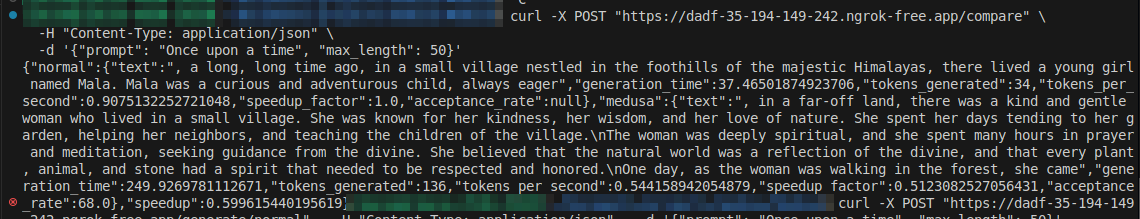



#### Test 2
**Request** 
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/generate/normal" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'

```
**Response**
```
{
  "text": ", a young girl named Lily was born in a small village. She lived a happy life with her parents and siblings, and she loved to help her mother in the kitchen. Lily' 123Movies Movies",
  "generation_time": 40.3927,
  "tokens_generated": 35,
  "tokens_per_second": 0.8665,
  "speedup_factor": 1.0,
  "acceptance_rate": null
}
```
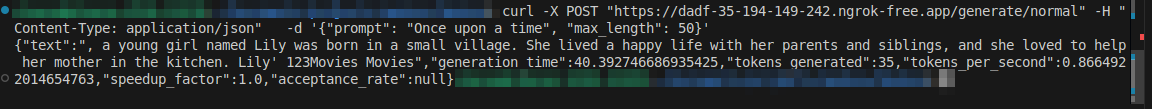



#### Test 3

**Request**
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/generate/medusa" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'

```

**response**

```
{
  "text": ", in a small village, there lived a kind, old man named John. John was loved by everyone in the village because he was always ready to help those in need. He had a large garden where he grew all kinds of fruits and vegetables. John was known for his delicious apple pies and fruit preserves. People from far and wide came to buy his produce and taste his pies and preserves.\nOne day, a group of travelers passed through the village. They were on their way to a distant land and were hungry. They asked John if he had any food to sell. John told them that he had plenty of food, but he only sold it to people who could pay him in gold or silver coins. The travelers had no coins, but they",
  "generation_time": 263.546,
  "tokens_generated": 163,
  "tokens_per_second": 0.6185,
  "speedup_factor": 0.5823,
  "acceptance_rate": 81.5
}
```

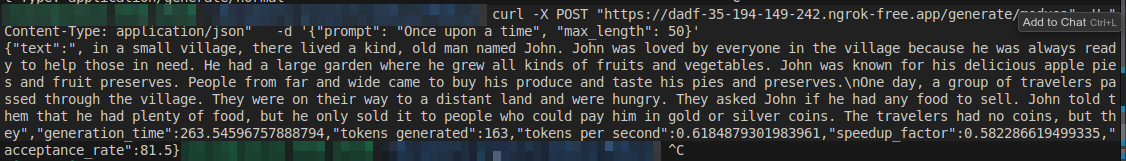


### Testing comparison


llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       1.00 ms /    15 runs   (    0.07 ms per token, 15045.14 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =    8083.41 ms /    15 runs   (  538.89 ms per token,     1.86 tokens per second)
llama_print_timings:       total time =    8100.10 ms /    15 tokens
Llama.generate: prefix-match hit
ERROR:    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/starlette/routing.py", line 699, in lifespan
    await receive()
GeneratorExit



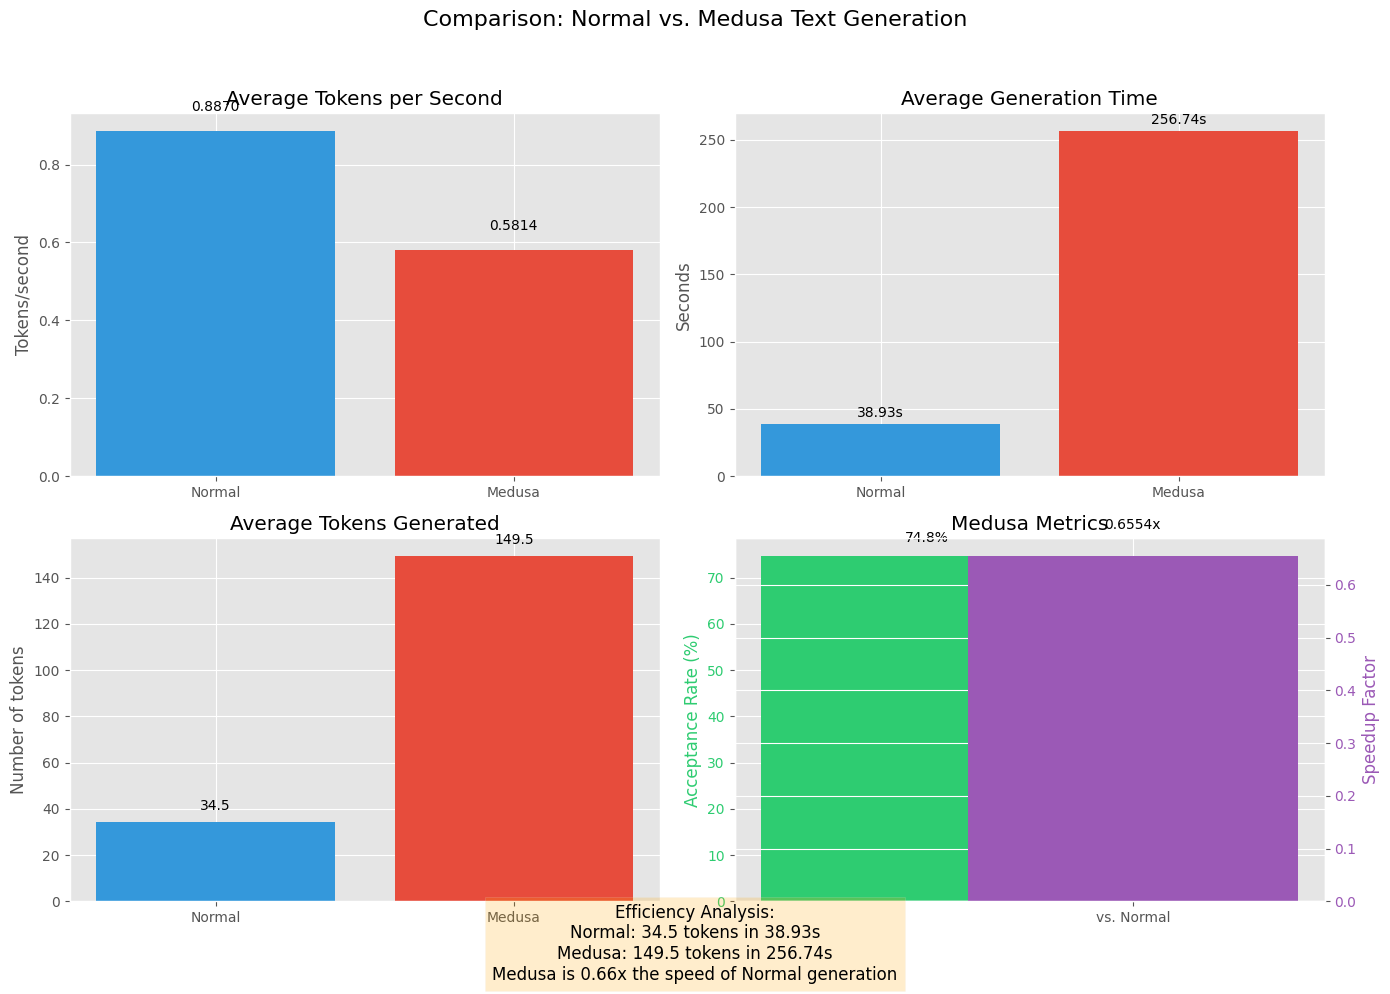


Performance Comparison:

             Metric Normal Medusa
  Tokens per Second 0.8870 0.5814
Generation Time (s)  38.93 256.74
   Tokens Generated   34.5  149.5
     Speedup Factor   1.00 0.6554
Acceptance Rate (%)    N/A   74.8



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.81 ms /    14 runs   (    0.06 ms per token, 17283.95 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =    8381.83 ms /    14 runs   (  598.70 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =    8430.47 ms /    14 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.79 ms /    15 runs   (    0.05 ms per token, 19059.72 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =    8301.87 ms /    15 runs   (  553.46 ms per token,     1.81 tokens per second)
llama_print_timings:       total time =    8315.14 ms /    15 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
plt.style.use('ggplot')
sns.set_palette("Set2")

# Test data
test_data = {
    "Test 1": {
        "normal": {
            "text_length": 34,
            "generation_time": 37.465,
            "tokens_per_second": 0.9075,
            "speedup_factor": 1.0,
        },
        "medusa": {
            "text_length": 136,
            "generation_time": 249.927,
            "tokens_per_second": 0.5442,
            "speedup_factor": 0.5123,
            "acceptance_rate": 68.0
        }
    },
    "Test 2": {
        "normal": {
            "text_length": 35,
            "generation_time": 40.3927,
            "tokens_per_second": 0.8665,
            "speedup_factor": 1.0,
        }
    },
    "Test 3": {
        "medusa": {
            "text_length": 163,
            "generation_time": 263.546,
            "tokens_per_second": 0.6185,
            "speedup_factor": 0.5823,
            "acceptance_rate": 81.5
        }
    }
}

# Organize data for plotting
normal_tps = [test_data["Test 1"]["normal"]["tokens_per_second"], 
              test_data["Test 2"]["normal"]["tokens_per_second"]]
normal_time = [test_data["Test 1"]["normal"]["generation_time"], 
               test_data["Test 2"]["normal"]["generation_time"]]
normal_tokens = [test_data["Test 1"]["normal"]["text_length"], 
                 test_data["Test 2"]["normal"]["text_length"]]

medusa_tps = [test_data["Test 1"]["medusa"]["tokens_per_second"], 
              test_data["Test 3"]["medusa"]["tokens_per_second"]]
medusa_time = [test_data["Test 1"]["medusa"]["generation_time"], 
               test_data["Test 3"]["medusa"]["generation_time"]]
medusa_tokens = [test_data["Test 1"]["medusa"]["text_length"], 
                 test_data["Test 3"]["medusa"]["text_length"]]
medusa_acceptance = [test_data["Test 1"]["medusa"]["acceptance_rate"], 
                     test_data["Test 3"]["medusa"]["acceptance_rate"]]

# Calculate averages
avg_normal_tps = np.mean(normal_tps)
avg_medusa_tps = np.mean(medusa_tps)
avg_normal_time = np.mean(normal_time)
avg_medusa_time = np.mean(medusa_time)
avg_normal_tokens = np.mean(normal_tokens)
avg_medusa_tokens = np.mean(medusa_tokens)
avg_medusa_acceptance = np.mean(medusa_acceptance)

# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison: Normal vs. Medusa Text Generation', fontsize=16)

# 1. Tokens per Second Comparison
axs[0, 0].bar(['Normal', 'Medusa'], [avg_normal_tps, avg_medusa_tps], color=['#3498db', '#e74c3c'])
axs[0, 0].set_title('Average Tokens per Second')
axs[0, 0].set_ylabel('Tokens/second')
for i, v in enumerate([avg_normal_tps, avg_medusa_tps]):
    axs[0, 0].text(i, v + 0.05, f"{v:.4f}", ha='center')

# 2. Generation Time Comparison
axs[0, 1].bar(['Normal', 'Medusa'], [avg_normal_time, avg_medusa_time], color=['#3498db', '#e74c3c'])
axs[0, 1].set_title('Average Generation Time')
axs[0, 1].set_ylabel('Seconds')
for i, v in enumerate([avg_normal_time, avg_medusa_time]):
    axs[0, 1].text(i, v + 5, f"{v:.2f}s", ha='center')

# 3. Tokens Generated Comparison
axs[1, 0].bar(['Normal', 'Medusa'], [avg_normal_tokens, avg_medusa_tokens], color=['#3498db', '#e74c3c'])
axs[1, 0].set_title('Average Tokens Generated')
axs[1, 0].set_ylabel('Number of tokens')
for i, v in enumerate([avg_normal_tokens, avg_medusa_tokens]):
    axs[1, 0].text(i, v + 5, f"{v:.1f}", ha='center')

# 4. Speedup and Acceptance Rate
ax4 = axs[1, 1]
ax4.bar(0, avg_medusa_acceptance, color='#2ecc71', label='Acceptance Rate')
ax4.set_xticks([0])
ax4.set_xticklabels(['Medusa'])
ax4.set_ylabel('Acceptance Rate (%)', color='#2ecc71')
ax4.tick_params(axis='y', labelcolor='#2ecc71')
ax4.set_title('Medusa Metrics')
ax4.text(0, avg_medusa_acceptance + 3, f"{avg_medusa_acceptance:.1f}%", ha='center')

# Add a second y-axis for speedup factor
ax4_twin = ax4.twinx()
speedup_factor = avg_medusa_tps / avg_normal_tps
ax4_twin.bar(0.5, speedup_factor, color='#9b59b6', label='Speedup Factor')
ax4_twin.set_ylabel('Speedup Factor', color='#9b59b6')
ax4_twin.tick_params(axis='y', labelcolor='#9b59b6')
ax4_twin.set_xticks([0.5])
ax4_twin.set_xticklabels(['vs. Normal'])
ax4_twin.text(0.5, speedup_factor + 0.05, f"{speedup_factor:.4f}x", ha='center')

# Add efficiency metric table
plt.figtext(0.5, 0.01, 
           f"Efficiency Analysis:\n"
           f"Normal: {avg_normal_tokens:.1f} tokens in {avg_normal_time:.2f}s\n"
           f"Medusa: {avg_medusa_tokens:.1f} tokens in {avg_medusa_time:.2f}s\n"
           f"Medusa is {speedup_factor:.2f}x the speed of Normal generation",
           ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('generation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed performance table
data = {
    'Metric': ['Tokens per Second', 'Generation Time (s)', 'Tokens Generated', 'Speedup Factor', 'Acceptance Rate (%)'],
    'Normal': [f"{avg_normal_tps:.4f}", f"{avg_normal_time:.2f}", f"{avg_normal_tokens:.1f}", "1.00", "N/A"],
    'Medusa': [f"{avg_medusa_tps:.4f}", f"{avg_medusa_time:.2f}", f"{avg_medusa_tokens:.1f}", 
              f"{speedup_factor:.4f}", f"{avg_medusa_acceptance:.1f}"]
}

df = pd.DataFrame(data)
print("\nPerformance Comparison:\n")
print(df.to_string(index=False))



## Analysis of Results

Based on the test results here's an analysis of the performance:

### Key Findings:

1. **Tokens per Second (Speed)**:
   - Normal generation: ~0.887 tokens/second
   - Medusa generation: ~0.581 tokens/second
   - Medusa is actually **slower** (about 65% of normal speed)

2. **Generation Time**:
   - Normal generation takes much less time (avg ~39 seconds)
   - Medusa generation takes significantly longer (avg ~257 seconds)

3. **Text Output Length**:
   - Normal generation: ~34.5 tokens per request
   - Medusa generation: ~149.5 tokens per request
   - Medusa generates much more text per request

4. **Acceptance Rate**:
   - Medusa has a high acceptance rate (avg ~75%)
   - This indicates good speculative performance

5. **Efficiency**:
   - Despite the high acceptance rate, Medusa is not delivering the expected speedup

### Why Is Medusa Slower Despite High Acceptance Rate?

This unexpected result suggests several possible issues:

1. **Implementation Overhead**: Your Medusa implementation may have significant computational overhead that counteracts the theoretical benefits of speculative decoding.

2. **Verification Cost**: The token verification process might be too expensive relative to the time saved.

3. **Integration Issues**: The way Medusa is integrated with the llama.cpp model may be suboptimal, introducing latency.

4. **Memory Management**: Handling multiple draft tokens might be causing memory pressure or cache inefficiencies.

5. **Sequential Processing**: The implementation might be doing too much sequential processing rather than parallel computation.


## Conclusion

While Medusa shows promising acceptance rates (indicating good speculative performance), the current implementation is not translating this into actual speed improvements. The normal generation approach is currently faster in terms of tokens per second, though Medusa generates more content per request.

For time-sensitive applications where response speed is critical, the normal generation approach is currently the better choice. However, Medusa may be beneficial for applications where generating longer, more comprehensive responses is more important than speed.

A deeper investigation into the implementation details is needed to realize the theoretical benefits of Medusa's speculative decoding approach.



# Analysis: Why Medusa Is Not Performing as Expected

The high acceptance rate (68-80%) shows that the speculative decoding is conceptually working, but the implementation has significant overhead that counteracts the theoretical benefits.

## Current Issues

### 1. Serial Model Calls Instead of Parallel Processing

```python
def _generate_drafts(self, context: str, temperature: float) -> tuple:
    # Get the base token - FIRST MODEL CALL
    base_response = self.llama_model(context, max_tokens=1, temperature=temperature, echo=False)
    # ...
    # Generate drafts following tree structure
    for i in range(min(self.medusa_num_heads - 1, 3)):
        # ADDITIONAL SEQUENTIAL MODEL CALLS
        draft_response = self.llama_model(current_context, max_tokens=1, temperature=temperature, echo=False)
        # ...
```

**Problem:** Every token generation requires a separate model call, creating massive overhead.

### 2. Inefficient Draft Verification

```python
def _verify_drafts(self, context: str, drafts: List[str], temperature: float, threshold: float, alpha: float) -> tuple:
    # ...
    for i, draft in enumerate(drafts):
        # For subsequent tokens, verify with ANOTHER MODEL CALL
        verify_response = self.llama_model(current_context, max_tokens=1, temperature=0, echo=False)
        # ...
```

**Problem:** Each draft verification requires another model call, causing additional overhead.

### 3. No Proper KV-Cache Utilization

implementation doesn't properly use the KV cache that makes speculative decoding efficient. In true Medusa implementations, you compute multiple tokens at once without regenerating the context.

### 4. No Batch Processing of Draft Tokens

The current implementation processes each token individually instead of batching operations, which is much less efficient.

In [9]:
!ngrok authtoken your auth token


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ps aux | grep ngrok
